## 1. Exploratory Data Analysis

## Table of contents

1. [Get the data and read it to pandas](#getdata)
2. [Info Summary](#summarydata)
3. [Class Distribution](#classdist)
4. [Check Frequent and Uncommon Words](#topwords)
    1. [Top 50 Most Frequent Words](#top50)
    1. [Uncommon](#uncommon)
4. [Distribution of Tokens per Document](#distpertoken)

### 1. Get the data and read it to pandas <a name="getdata"></a>


In [1]:
!ls ./data/raw

tech_soft_none.json


In [2]:
!wget "https://drive.google.com/uc?id=1bYFMJ6cz7xm1zDD5Avm5JMz8pp4geRHE&export=download" -q -O ./data/raw/tech_soft_none.json

In [3]:
!ls ./data/raw/

tech_soft_none.json


In [4]:
# check file format
!head -n 10 ./data/raw/tech_soft_none.json

{
    "data": [
        {
            "text": "Standort Trovarit AG München, Deutschland",
            "label": "none"
        },
        {
            "text": "Wir freuen uns auf Ihre Bewerbung unter Angabe Ihrer Gehaltsvorstellung und Ihres möglichen Eintrittstermins. Der ALTE LEIPZIGER – HALLESCHE Konzern begrüßt ausdrücklich die Bewerbung von Menschen mit Behinderung. Bei Fragen und für weitere Informationen wenden Sie sich gerne an Elke Lang unter 0711-6603-2411 . Ihre ausführlichen Bewerbungsunterlagen senden Sie bitte an bewerbung@hallesche.de oder per Post an: HALLESCHE Krankenversicherung a. G. Personal und Soziales Reinsburgstraße 10 70178 Stuttgart www.hallesche.de",
            "label": "none"
        },


In [5]:
import pandas as pd 
import json
import matplotlib.pyplot as plt

*Notes*:

Load the json data then flatten it with pandas

In [6]:
data_raw = "./data/raw/tech_soft_none.json"

In [7]:
with open(data_raw, 'r') as f: 
    data = json.loads(f.read())

In [8]:
# Transform it to Pandas DataFrame
skills_df = pd.json_normalize(data, record_path = ["data"])

In [9]:
skills_df.head()

,text,label
0,"Standort Trovarit AG München, Deutschland",none
1,Wir freuen uns auf Ihre Bewerbung unter Angabe...,none
2,Qualifikation zur Heimleitung gemäß Heimperson...,tech
3,Gute organisatorische und konzeptionelle Fähig...,soft
4,"Teamfähigkeit, hohe Flexibilität und Einsatzbe...",soft


**Notes**: 

Great now that we have the data in a DataFrame, let's do some Data Analysis to understand better our data

## 1.2 Check info summary of data <a name="summarydata"></a>

Looking at the table below, we can observe: 

- We have 10.249 records, all of them are non-null which will make it easier for processing the data

In [10]:
skills_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10249 entries, 0 to 10248
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10249 non-null  object
 1   label   10249 non-null  object
dtypes: object(2)
memory usage: 160.3+ KB


## 1.3 Check Class Distribution <a name="classdist"></a>

Let's check how many classes are in the dataset and the distribution per class.

**Observations**: 
- We have 3 classes (none, soft and tech) skills
- Distribution of classes seems to be a bit unbalanced with regards to `tech` class where only 22% of the dataset represents the class
    - `none`: 42.19 % 
    - `soft`: 35.46 %
    - `tech`: 22.33 %
    
**Considerations on model creation**: 
- The minority class `tech` might suffer from the imbalance at prediction time, we might want to check options like downsampling/upsampling or weighing of the classes to help with this issue

In [11]:
skills_df['label'].value_counts() / skills_df['label'].shape

none    0.421992
soft    0.354669
tech    0.223339
Name: label, dtype: float64

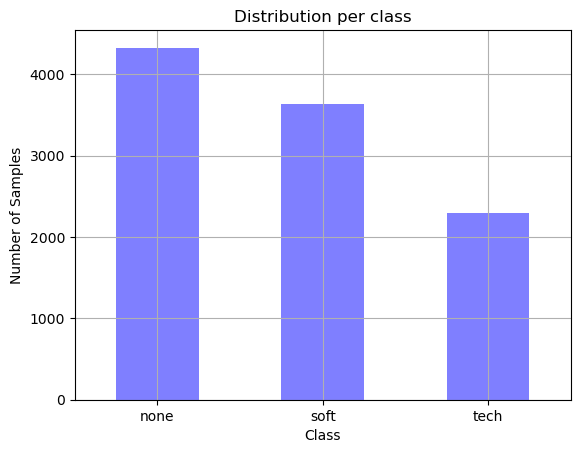

In [12]:
skills_df["label"].value_counts().sort_index().plot.bar(rot=0, grid=True, color="blue", alpha=0.5)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Distribution per class")
plt.show()

## 1.4 Checking Top-Frequent and Uncommon words  <a name="topwords"></a>

By doing this check we can analyse if it's necessary to add additional stop words to our model, as certain words might not contribute to our model. 

Yet another interesting analysis we can perform is to observe the uncommon words, as they might signal our model towards specific prediction of a particular class

In [13]:
import spacy
from spacy.tokens import Doc

In [14]:
de_model = "de_core_news_lg"
nlp = spacy.load(de_model)
de_stop_words = nlp.Defaults.stop_words

####  Let's incorporate to the pipe a lenght of the Doc that is being processed 

In [15]:
def len_doc(doc): 
    doc_length = len(doc)
    return doc_length

def len_doc_only_alpha(doc): 
    doc_length = sum([1 if token.is_alpha else 0 for token in doc])
    return doc_length

# Set the extension on the doc so we can plot it later
Doc.set_extension("doc_len", getter=len_doc, force=True)
Doc.set_extension("doc_len_alpha", getter=len_doc_only_alpha, force=True)

Let's convert the text to Doc using spaCy, so we can obtain frequencies more easily

In [16]:
# Let's transform it to list 
raw_text = skills_df['text'].to_list()

# Let's check the tokenizer of the first 5 sentences
for doc in nlp.pipe(raw_text[:5]):
    print(f"Tokens:{[token.text for token in doc]}, \nDoc length:{doc._.doc_len}, \nDoc length (only alpha):{doc._.doc_len_alpha}")
    print("------------------------------------")

Tokens:['Standort', 'Trovarit', 'AG', 'München', ',', 'Deutschland'], 
Doc length:6, 
Doc length (only alpha):5
------------------------------------
Tokens:['Wir', 'freuen', 'uns', 'auf', 'Ihre', 'Bewerbung', 'unter', 'Angabe', 'Ihrer', 'Gehaltsvorstellung', 'und', 'Ihres', 'möglichen', 'Eintrittstermins', '.', 'Der', 'ALTE', 'LEIPZIGER', '–', 'HALLESCHE', 'Konzern', 'begrüßt', 'ausdrücklich', 'die', 'Bewerbung', 'von', 'Menschen', 'mit', 'Behinderung', '.', 'Bei', 'Fragen', 'und', 'für', 'weitere', 'Informationen', 'wenden', 'Sie', 'sich', 'gerne', 'an', 'Elke', 'Lang', 'unter', '0711', '-', '6603', '-', '2411', '.', 'Ihre', 'ausführlichen', 'Bewerbungsunterlagen', 'senden', 'Sie', 'bitte', 'an', 'bewerbung@hallesche.de', 'oder', 'per', 'Post', 'an', ':', 'HALLESCHE', 'Krankenversicherung', 'a.', 'G.', 'Personal', 'und', 'Soziales', 'Reinsburgstraße', '10', '70178', 'Stuttgart', 'www.hallesche.de'], 
Doc length:75, 
Doc length (only alpha):59
------------------------------------
Token

In [17]:
%%time
docs = []
tokens = []
for doc in nlp.pipe(raw_text, batch_size=100):
    docs.append(doc)
    tokens.append([token.text for token in doc if token.is_alpha])

CPU times: user 16.6 s, sys: 375 ms, total: 17 s
Wall time: 17.1 s


In [18]:
## Assign it to the DF 
skills_df['doc'] = pd.Series(docs)
skills_df['tokens'] = pd.Series(tokens)
skills_df.head(3)

,text,label,doc,tokens
0,"Standort Trovarit AG München, Deutschland",none,"(Standort, Trovarit, AG, München, ,, Deutschland)","[Standort, Trovarit, AG, München, Deutschland]"
1,Wir freuen uns auf Ihre Bewerbung unter Angabe...,none,"(Wir, freuen, uns, auf, Ihre, Bewerbung, unter...","[Wir, freuen, uns, auf, Ihre, Bewerbung, unter..."
2,Qualifikation zur Heimleitung gemäß Heimperson...,tech,"(Qualifikation, zur, Heimleitung, gemäß, Heimp...","[Qualifikation, zur, Heimleitung, gemäß, Heimp..."


**Let's check the first sentence and how it was processed by the model**

In [19]:
raw_text[1]

'Wir freuen uns auf Ihre Bewerbung unter Angabe Ihrer Gehaltsvorstellung und Ihres möglichen Eintrittstermins. Der ALTE LEIPZIGER – HALLESCHE Konzern begrüßt ausdrücklich die Bewerbung von Menschen mit Behinderung. Bei Fragen und für weitere Informationen wenden Sie sich gerne an Elke Lang unter 0711-6603-2411 . Ihre ausführlichen Bewerbungsunterlagen senden Sie bitte an bewerbung@hallesche.de oder per Post an: HALLESCHE Krankenversicherung a. G. Personal und Soziales Reinsburgstraße 10 70178 Stuttgart www.hallesche.de'

In [20]:
print(len(tokens[1]), tokens[1])

59 ['Wir', 'freuen', 'uns', 'auf', 'Ihre', 'Bewerbung', 'unter', 'Angabe', 'Ihrer', 'Gehaltsvorstellung', 'und', 'Ihres', 'möglichen', 'Eintrittstermins', 'Der', 'ALTE', 'LEIPZIGER', 'HALLESCHE', 'Konzern', 'begrüßt', 'ausdrücklich', 'die', 'Bewerbung', 'von', 'Menschen', 'mit', 'Behinderung', 'Bei', 'Fragen', 'und', 'für', 'weitere', 'Informationen', 'wenden', 'Sie', 'sich', 'gerne', 'an', 'Elke', 'Lang', 'unter', 'Ihre', 'ausführlichen', 'Bewerbungsunterlagen', 'senden', 'Sie', 'bitte', 'an', 'oder', 'per', 'Post', 'an', 'HALLESCHE', 'Krankenversicherung', 'Personal', 'und', 'Soziales', 'Reinsburgstraße', 'Stuttgart']


## 1.4.1 **Top-50 most Frequent Words**  <a name="top50"></a>

*Observation notes*: 

- We can see the most common words are usually words that are stopwords, like `und`, `mit`. 
- 62% of the Top 50 frequent words are stopwords. We should check this at the time we are performing modeling, sometimes this is not relevant for models, but for Classification it might, for example: 
    - If we are predicting something like having certain skills or not and someone puts that it doesn't perform well under pressure, and we remove the negation, the classifier might predict otherwise. 
    - On this particular case it might be Ok, but we will see in our set of experiments

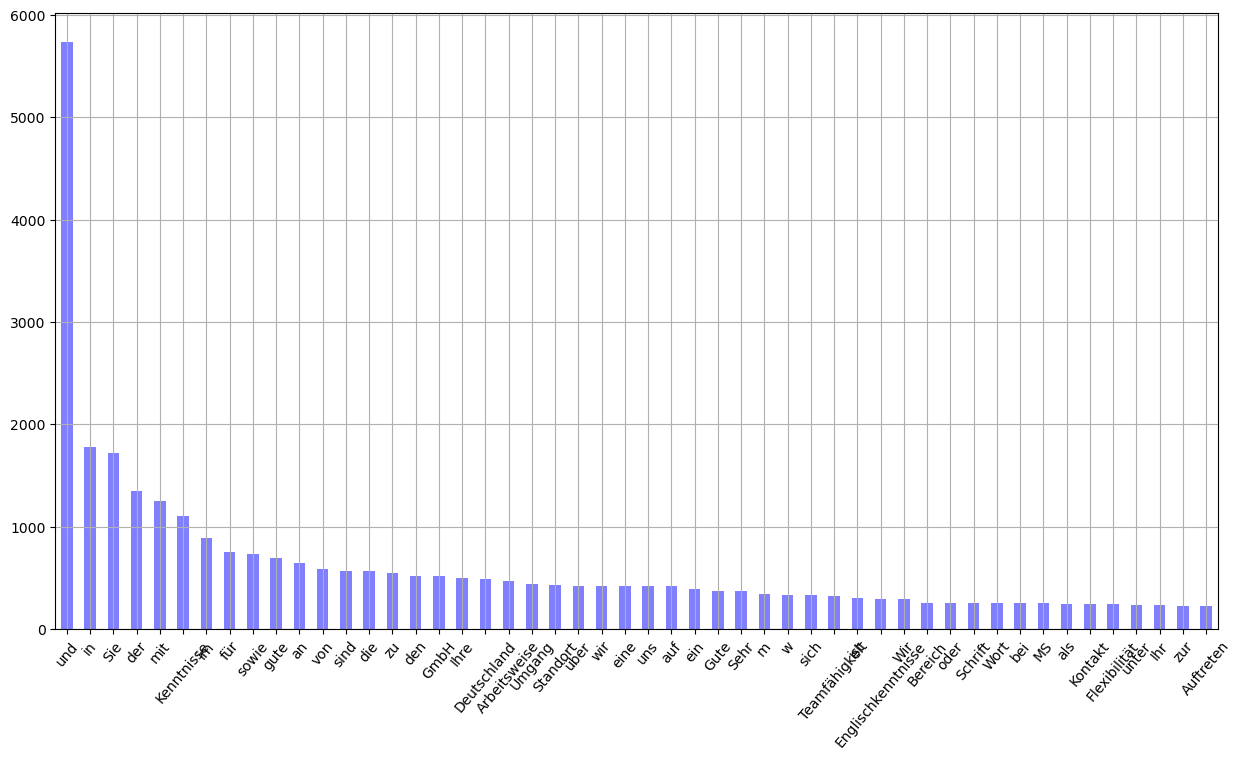

In [21]:
word_by_frequency = pd.Series(" ".join(skills_df["tokens"].apply(lambda t: " ".join(t))).split()).value_counts()
top_50_words = word_by_frequency[:50]
plt.figure(figsize=(15,8))
top_50_words.plot.bar(rot=0, grid=True, color="blue", alpha=0.5)

plt.xticks(rotation = 50)
plt.show()

In [22]:
top_50_df = top_50_words.to_frame().reset_index()
top_50_df.rename(columns = {'index':'word'}, inplace=True)
top_50_df.head()

,word,0
0,und,5732
1,in,1778
2,Sie,1717
3,der,1347
4,mit,1248


In [23]:
top_50_df['word'].isin(de_stop_words).value_counts()

True     27
False    23
Name: word, dtype: int64

**Check the words that are not stop words in the top 50** 

- `kenntnisse` --> Knowledge
- `arbeitsweise` --> Way of working 
- `teamfähigkeit` --> Team Work 
- `englischkenntnisse` --> Knows english


We can see this might be signals that could be used by the classifier to effectively perform its prediction towards certain skill

In [24]:
top_50_df[top_50_df['word'].isin(de_stop_words) == False]

,word,0
2,Sie,1717
5,Kenntnisse,1105
16,GmbH,514
17,Ihre,500
18,Deutschland,486
19,Arbeitsweise,474
20,Umgang,436
21,Standort,426
28,Gute,376
29,Sehr,372


### 1.4.2 Uncommon words <a name="uncommon"></a>

Let's check the uncommon words as it also might give us some guidance of words that might not be useful for the model.

**Observation Notes**: 

- It seems a big part of the uncommon words refers to specifics of a skill such as:
    - `Cloudservices`
    - `FrameMaker`
    - `NetApp`
    - `Storagelösungen` --> Storage solutions

In [25]:
uncommon_words = word_by_frequency[-30:]
uncommon_words

Healthcheck                1
Bypassing                  1
Gültige                    1
ESX                        1
umsetzungsstarke           1
Bürogebäude                1
Oh                         1
my                         1
Maximalgröße               1
überschreiten              1
Cloudservices              1
annehmen                   1
FrameMaker                 1
NetApp                     1
Isilon                     1
EMC                        1
Storagelösungen            1
Interfaces                 1
Anwendungsmöglichkeiten    1
Tatsachen                  1
scheinbare                 1
Damenschuhe                1
Spitzenstellung            1
Schuhherstellern           1
bedeutendsten              1
Gebäudebestand             1
umfangreichen              1
übergemeindlichen          1
Kirchengemeinden           1
WPR                        1
dtype: int64

## 1.5 Distribution of Tokens per Document and per class <a name="distpertoken"></a>

**Notes**:
- We can observe we have a long tailed distribution of tokens per document, where:
    - Average doc len is around 8 tokens per Document 
    - Max tokens per doc is 213 
    - Min tokens per doc is 0: (**We should take a look into this as we might need to remove it before training**)

In [26]:
import seaborn as sns

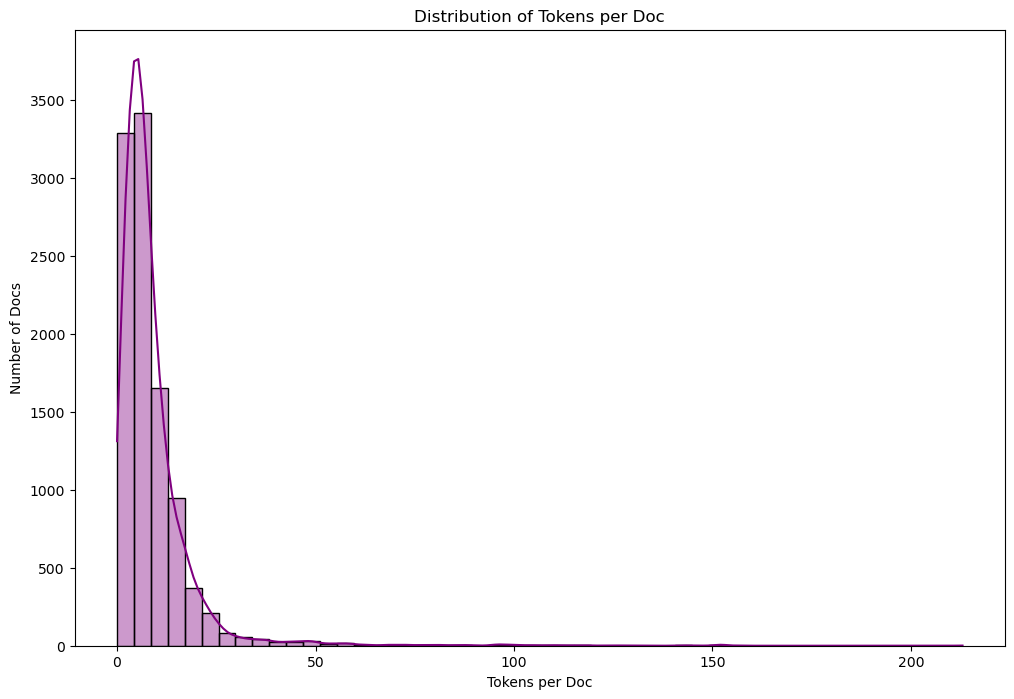

In [27]:
df_dist_tokens_per_doc = skills_df['doc'].apply(lambda d: d._.doc_len_alpha).to_frame()
plt.figure(figsize=(12,8))
sns.histplot(df_dist_tokens_per_doc["doc"], kde=True, stat="count", color='purple', alpha=0.4, bins=50)
plt.xlabel("Tokens per Doc")
plt.ylabel("Number of Docs")
plt.title("Distribution of Tokens per Doc")
plt.show()

In [28]:
df_dist_tokens_per_doc["doc"].describe()

count    10249.000000
mean         8.855596
std         10.781777
min          0.000000
25%          4.000000
50%          6.000000
75%         11.000000
max        213.000000
Name: doc, dtype: float64

Let's calculate the number of Docs where the size of tokens is empty and also check how many per class

*Notes*
- 2% of Documents ( around 200~) are empty, we will remove this at cleaning time. 
- Observing a sample of this documents, we can see that much of them were removed because we have filtered by alpha and they contain hyphens, or only numbers. 
- Some of this examples with hyphens are skills like: `EDV-Anwenderkenntnisse` --> IT user skills, this might add value to our classifier but for now let's leave it out. ( We can revisit later on )

In [29]:
ratio_empty = df_dist_tokens_per_doc[df_dist_tokens_per_doc['doc'] < 1].shape[0]/skills_df.shape[0] * 100
print(f"Ratio of empty docs after cleaning: {round(ratio_empty)}%")

Ratio of empty docs after cleaning: 2%


In [30]:
skills_df.iloc[df_dist_tokens_per_doc[df_dist_tokens_per_doc['doc'] < 1].index].head(10)

,text,label,doc,tokens
39,Pkw-Führerschein,soft,(Pkw-Führerschein),[]
420,IT-Affinität.,tech,"(IT-Affinität, .)",[]
424,Www.bode-chemie.de.,none,"(Www.bode-chemie.de, .)",[]
427,KFZ-Führerschein,tech,(KFZ-Führerschein),[]
527,Hands-on-Mentalität.,soft,"(Hands-on-Mentalität, .)",[]
528,Junior-Vertriebsmitarbeiter/-in,none,(Junior-Vertriebsmitarbeiter/-in),[]
604,EDV-Anwenderkenntnisse,tech,(EDV-Anwenderkenntnisse),[]
616,MS-Office-Know-how.,tech,"(MS-Office-Know-how, .)",[]
699,VPN-Bausteine Internet-Bausteine Telefonie-Bau...,none,"(VPN-Bausteine, Internet-Bausteine, Telefonie-...",[]
876,+49 (0) 49 54 - 89 3 88-100,none,"(+49, (, 0, ), 49, 54, -, 89, 3, 88, -, 100)",[]
